## Imports

In [1]:
import os
import math
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
from pyRMG.valence import ONCVValences
from pyRMG.rmg_log import RMGLog
from pyRMG.rmg_input import RMGInput
from pyRMG.forcefield import Forcefield
from pyRMG.convergence import RMGConvergence
from scipy.linalg import sqrtm
from parse2fit.io.parsers import RMGParser
from pymatgen.analysis.elasticity.strain import Strain

## Parsing Functions

In [2]:
import ast
import re
from pathlib import Path
from typing import List, Optional
import numpy as np

In [3]:
def get_value_from_lines(lines: List[str], key: str) -> Optional[str]:
    """
    Search a list of text lines (e.g., file.readlines()) for a top-level dictionary
    entry named `key` and return the raw string for its value (trimmed).
    Returns None if not found.

    Looks for patterns like:
      'key': value,
      "key": value,
    and handles multi-line values with nested brackets/parentheses until they close.
    """
    # combine into list if it's a single string
    if isinstance(lines, str):
        lines = lines.splitlines()

    # Pre-compile simple regex to detect the key in a line
    key_re = re.compile(rf"""['"]{re.escape(key)}['"]\s*:\s*(.*)""")

    i = 0
    n = len(lines)
    while i < n:
        line = lines[i]
        m = key_re.search(line)
        if not m:
            i += 1
            continue

        # remainder after "key:" on this line
        remainder = m.group(1).rstrip()
        # If remainder is empty, start reading next line(s)
        if remainder == "":
            i += 1
            if i >= n:
                return ""
            remainder = lines[i].lstrip()

        # Trim trailing comment-like fragments (rare), but keep brackets/quotes
        # If value looks like a simple literal that ends on this line (ends with comma or brace),
        # strip trailing comma/brace and return.
        # But if it starts with an opening bracket/paren, we need to read until matching close.
        val = remainder

        # If this value looks like it ends here (ends with , or } or ) ), take it (strip trailing comma/braces)
        simple_end = re.search(r"[,\}\)]\s*$", val) is not None

        # detect starting token that requires balancing
        start_char = val.lstrip()[0] if val.lstrip() else ''
        multi_start = start_char in "([{"
        # also handle wrappers like array(  which start with name + '('
        wrapper_call = re.match(r"\s*([A-Za-z_]\w*)\s*\(", val)

        if not multi_start and not wrapper_call:
            # not an obvious multiline start — return until the first trailing comma or closing brace
            # trim trailing comma and any trailing braces
            raw = re.split(r"[,\}]\s*$", val)[0].strip()
            return raw
        else:
            # we need to balance parentheses/brackets across lines.
            # Build a stream from the current remainder (starting at its first non-space char)
            buf = val.rstrip("\n")
            # If wrapper_call matched but the remainder does not contain closing ')', we still balance.
            # Initialize counters for parentheses/brackets/braces
            paren = 0
            brack = 0
            brace = 0

            # process existing part
            for ch in buf:
                if ch == "(":
                    paren += 1
                elif ch == ")":
                    paren -= 1
                elif ch == "[":
                    brack += 1
                elif ch == "]":
                    brack -= 1
                elif ch == "{":
                    brace += 1
                elif ch == "}":
                    brace -= 1

            j = i + 1
            # keep appending lines until all counters are <= 0 (balanced)
            while (paren > 0 or brack > 0 or brace > 0) and j < n:
                extra = lines[j].rstrip("\n")
                buf += "\n" + extra
                for ch in extra:
                    if ch == "(":
                        paren += 1
                    elif ch == ")":
                        paren -= 1
                    elif ch == "[":
                        brack += 1
                    elif ch == "]":
                        brack -= 1
                    elif ch == "{":
                        brace += 1
                    elif ch == "}":
                        brace -= 1
                j += 1

            # strip trailing comma if present at the very end
            buf = re.sub(r",\s*$", "", buf).strip()
            return buf

    # not found
    return None

In [4]:
# --- Convenience conversion helpers ---

def value_to_float(raw: str) -> float:
    """Convert a raw value string to float safely (strips trailing commas/braces)."""
    if raw is None:
        raise ValueError("raw value is None")
    s = raw.strip().rstrip(",").rstrip("}").strip()
    return float(s)

def value_to_int(raw: str) -> int:
    if raw is None:
        raise ValueError("raw value is None")
    s = raw.strip().rstrip(",").rstrip("}").strip()
    return int(s)

def value_to_numpy(raw: str) -> np.ndarray:
    """
    Try to convert a raw string (like 'array([[1,2],[3,4]])' or '[[1,2],[3,4]]')
    into a numpy array. Uses ast.literal_eval for safety on the inner literal.
    """
    if raw is None:
        raise ValueError("raw value is None")
    s = raw.strip()
    # remove trailing comma/braces
    s = s.rstrip(",").strip()

    # handle wrappers like array(...), Strain(...), np.array(...)
    m = re.match(r"^\s*([A-Za-z_]\w*)\s*\((.*)\)\s*$", s, flags=re.S)
    if m:
        inner = m.group(2).strip()
    else:
        inner = s

    # Now attempt a safe literal eval of inner (should be plain Python list/tuple of numbers)
    try:
        pyobj = ast.literal_eval(inner)
    except Exception:
        # As a fallback, try to coerce numeric tokens (less safe)
        # Replace multiple spaces and newlines, then eval in restricted env
        pyobj = eval(inner, {"__builtins__": None}, {})  # only run on trusted files

    arr = np.array(pyobj)
    return arr

In [5]:
def sort_lists_by_index(sort_index, *lists):
    if not lists:
        raise ValueError("At least one list must be provided")
    
    if any(len(lst) != len(lists[0]) for lst in lists):
        raise ValueError("All lists must have the same length")
    
    zipped_lists = list(zip(*lists))  # Zip the lists together
    sorted_lists = sorted(zipped_lists, key=lambda x: x[sort_index])  # Sort by the specified index
    
    return tuple(map(list, zip(*sorted_lists)))  # Unzip back into separate lists

def get_reference_energy(structure, energy, reference_logs):
    final_structures = [ref_log.logs_data[ref_log.logs_keys[-1]]['structures'][-1] for ref_log in reference_logs]
    elements_lst = [str(s[0].specie) for s in final_structures] # Get first element
    final_energies = [ref_log.logs_data[ref_log.logs_keys[-1]]['energies'][-1] for ref_log in reference_logs]
    ref_dict = {elements_lst[i]: final_energies[i]/len(final_structures[i]) for i, element in enumerate(elements_lst)}
    #print(ref_dict)
    
    structure_comp_dct = structure.composition.as_dict()
    comp_elements = list(structure_comp_dct.keys())
    #print(structure_comp_dct, comp_elements)
    energies_per_element = [structure_comp_dct[element] * ref_dict[element] for element in comp_elements]
    
    formation_energy = energy - sum(energies_per_element)
    formation_energy = formation_energy / len(structure) # Normalization per atom, in units Hartree/atom
    formation_energy *= 27.2114 # Conversion from Hartree/atom to eV/atom
            
    return formation_energy

def get_total_electrons(structure):
    return np.sum([ONCVValences().get_valence(str(site.specie)) for site in structure])

def get_from_top(path):
    rmg_input_path = os.path.join(path, 'rmg_input')
    forcefield_path = os.path.join(path, 'forcefield.xml')
    interface_path = os.path.join(path, 'interface.json')
        
    if os.path.exists(rmg_input_path):
        rmg_input = RMGInput(input_file=rmg_input_path)
        
        if os.path.exists(forcefield_path):
            forcefield = Forcefield(forcefield_xml_path=forcefield_path)
            convergence_checker = RMGConvergence(forcefield=forcefield, 
                                                 rmg_input=rmg_input)
            
            if convergence_checker.is_converged():
                rmg_log = RMGLog(path)
                return rmg_input, rmg_log, forcefield
            else:
                try:
                    rmg_log = RMGLog(path)
                except:
                    rmg_log = None
                return rmg_input, rmg_log, None
        else:
            return rmg_input, None, None
    else:
        return None, None, None

In [6]:
def get_rmg_logs_and_inputs(path, reference_path):
    reference_logs = []
    for root, _, _ in os.walk(reference_path):
        rmg_input, rmg_log, forcefield = get_from_top(root)
        if rmg_input:
            reference_logs.append(rmg_log)
    
    paths_dct = {}
    for root, _, _ in os.walk(path):
        rmg_input, rmg_log, forcefield = get_from_top(root)
        if rmg_input and rmg_log and forcefield:
            print(root)
            path_dct = {}
            path_dct['rmg_input'] = rmg_input
            path_dct['rmg_log'] = rmg_log
            last_log = rmg_log.logs_keys[-1]
                
            with open(last_log, 'r') as f:
                last_logfile_lines = f.readlines()

            interface_path = Path(os.path.join(root, 'properties.txt')).read_text()
            lines = interface_path.splitlines()
            #with open(interface_path, 'r') as j:
            #    interface_dct = json.load(j)
                
            correct_line = None
            for line in last_logfile_lines:
                if "1-TOTAL" in line:
                    correct_line = line
                    break
            split_timings = correct_line.split()

            with open(last_log, 'r') as f:
                last_logfile = f.read()

            pattern = r"spinup:\s+Band gap.*"
            matches = re.findall(pattern, last_logfile)
            if matches:
                bandgap = float(matches[-1].split()[-2])

            path_dct['valence_electrons'] = get_total_electrons(rmg_input.structure)
            path_dct['band_gap'] = bandgap
            path_dct['total_time'] = float(split_timings[1])
            path_dct['per_scf'] = float(split_timings[2])
            path_dct['wavefunction_grid'] = [int(i) for i in rmg_input.keywords['wavefunction_grid'].split()]
            path_dct['processor_grid'] = [int(i) for i in rmg_input.keywords['processor_grid'].split()]
            path_dct['kpoint_distribution'] = int(rmg_input.keywords.get('kpoint_distribution', 1))

            #path_dct['strain'] = get_value_from_lines(lines, "strain")
            path_dct['von_mises_strain'] = float(get_value_from_lines(lines, "von_mises_strain").split()[0].replace(',', ''))
            path_dct['signed_angle'] = float(get_value_from_lines(lines, "signed_angle").split()[0].replace(',', ''))
            #path_dct['substrate_sl_vectors'] = get_value_from_lines(lines, "substrate_sl_vectors")
            #path_dct['film_sl_vectors'] = get_value_from_lines(lines, 'film_sl_vectors')
            try:
                path_dct['decomposition_angle'] = float(get_value_from_lines(lines, "decomposition_angle"))
            except:
                pass

            final_structure = rmg_log.logs_data[last_log]['structures'][-1]
            final_energy = rmg_log.logs_data[last_log]['energies'][-1] 
            final_stress = RMGParser(root).parse_stress_vectors()
            
            path_dct['reduction_factor'] = [1, 1, 1 - (20/final_structure.lattice.c)]
            #print(final_stress)
            #path_dct['von_mises_stress'] = von_Mises_stress(final_stress)
            path_dct['formation_energy (meV/atom)'] = get_reference_energy(final_structure, 
                                                                    final_energy, 
                                                                    reference_logs)
            
            paths_dct[root] = path_dct
        else:
            continue
            #print(f'{rmg_input_path} not converged!')
            
    return paths_dct

## Parse converged single point RMG calculations

In [7]:
input_name = 'small_strain_single_points'
input_dct = get_rmg_logs_and_inputs(input_name, 'references')

small_strain_single_points/1014/13.54673/0.01073
small_strain_single_points/932/22.3381/0.01126
small_strain_single_points/894/26.51348/0.01183
small_strain_single_points/970/16.10211/0.00179
small_strain_single_points/970/6.90249/0.01076
small_strain_single_points/716/4.30662/0.00542
small_strain_single_points/796/26.08141/0.00724
small_strain_single_points/792/1.94512/0.006
small_strain_single_points/466/0.0/0.00232
small_strain_single_points/488/9.51534/0.00263
small_strain_single_points/1046/9.1247/0.00991
small_strain_single_points/1046/27.02125/0.00991
small_strain_single_points/846/24.73618/0.01297
small_strain_single_points/352/6.58678/0.00668
small_strain_single_points/358/17.48017/0.00542
small_strain_single_points/472/25.285/0.00687
small_strain_single_points/244/22.68889/0.00263
small_strain_single_points/1018/7.08848/0.01234
small_strain_single_points/992/20.0852/0.01048
small_strain_single_points/998/16.96715/0.01166
small_strain_single_points/998/9.04068/0.01166
small_st

## Format Data for Plotting Figure 3. 

In [8]:
def format_for_plotting(input_dct):
    electrons_per_gpu = []
    band_gaps = []
    total_times = []
    processor_grid = []
    reduction_factor = []
    grid_coefficient_of_variation = []
    von_mises_strain = []
    signed_angle = []
    new_angles = []
    mod_new_angles = []
    folded_mod_new_angles = []
    formation_energies = []
    num_atoms = []
    kpoint_distribution = []
    keys = []
    labels = []

    for key in list(input_dct.keys()):
        electrons_per_gpu.append(input_dct[key]['valence_electrons']/(math.prod(input_dct[key]['processor_grid'])*input_dct[key]['kpoint_distribution']))
        total_times.append(input_dct[key]['total_time'])
        try:
            band_gaps.append(input_dct[key]['band_gap'])
        except:
            band_gaps.append(None)
        von_mises_strain.append(input_dct[key]['von_mises_strain'])
        signed_angle.append(input_dct[key]['signed_angle'])
        try:
            new_angles.append(((input_dct[key]['decomposition_angle'])))
        except: 
            new_angles.append(((input_dct[key]['signed_angle'])))
        try:
            mod_new_angle = np.mod(input_dct[key]['decomposition_angle'], 60) 
        except: 
            mod_new_angle = np.mod(input_dct[key]['signed_angle'], 60) 
        mod_new_angle = np.where(mod_new_angle == 0, 60, mod_new_angle)
        mod_new_angles.append(mod_new_angle)
        folded_mod_new_angle = 30 - np.abs(mod_new_angle - 30)
        folded_mod_new_angles.append(folded_mod_new_angle)
        formation_energies.append(input_dct[key]['formation_energy (meV/atom)'])
        num_atoms.append(len(input_dct[key]['rmg_input'].structure))
        kpoint_distribution.append(input_dct[key]['kpoint_distribution'])
        processor_grid.append(input_dct[key]['processor_grid'])
        reduction_factor.append(input_dct[key]['reduction_factor'])
        grid_coefficient_of_variation.append(np.std(np.multiply(input_dct[key]['processor_grid'], 
                                               input_dct[key]['reduction_factor'])))
    
        keys.append(key)
        labels.append(os.path.join(*list(Path(key).parts[-3:])))

    plot_dct = {'electrons_per_gpu': electrons_per_gpu, 'band_gaps': band_gaps, 'total_times': total_times,
               'processor_grid': processor_grid, 'reduction_factor': reduction_factor, 
               'grid_coefficient_of_variation': grid_coefficient_of_variation, 'von_mises_strain': von_mises_strain, 
               'signed_angle': signed_angle, 'new_angles': new_angles, 'mod_new_angles': mod_new_angles, 
               'folded_mod_new_angles': folded_mod_new_angles, 'formation_energies': formation_energies, 
               'num_atoms': num_atoms, 'kpoint_distribution': kpoint_distribution, 'keys': keys, 'labels': labels}

    return plot_dct

# Figure 3. 

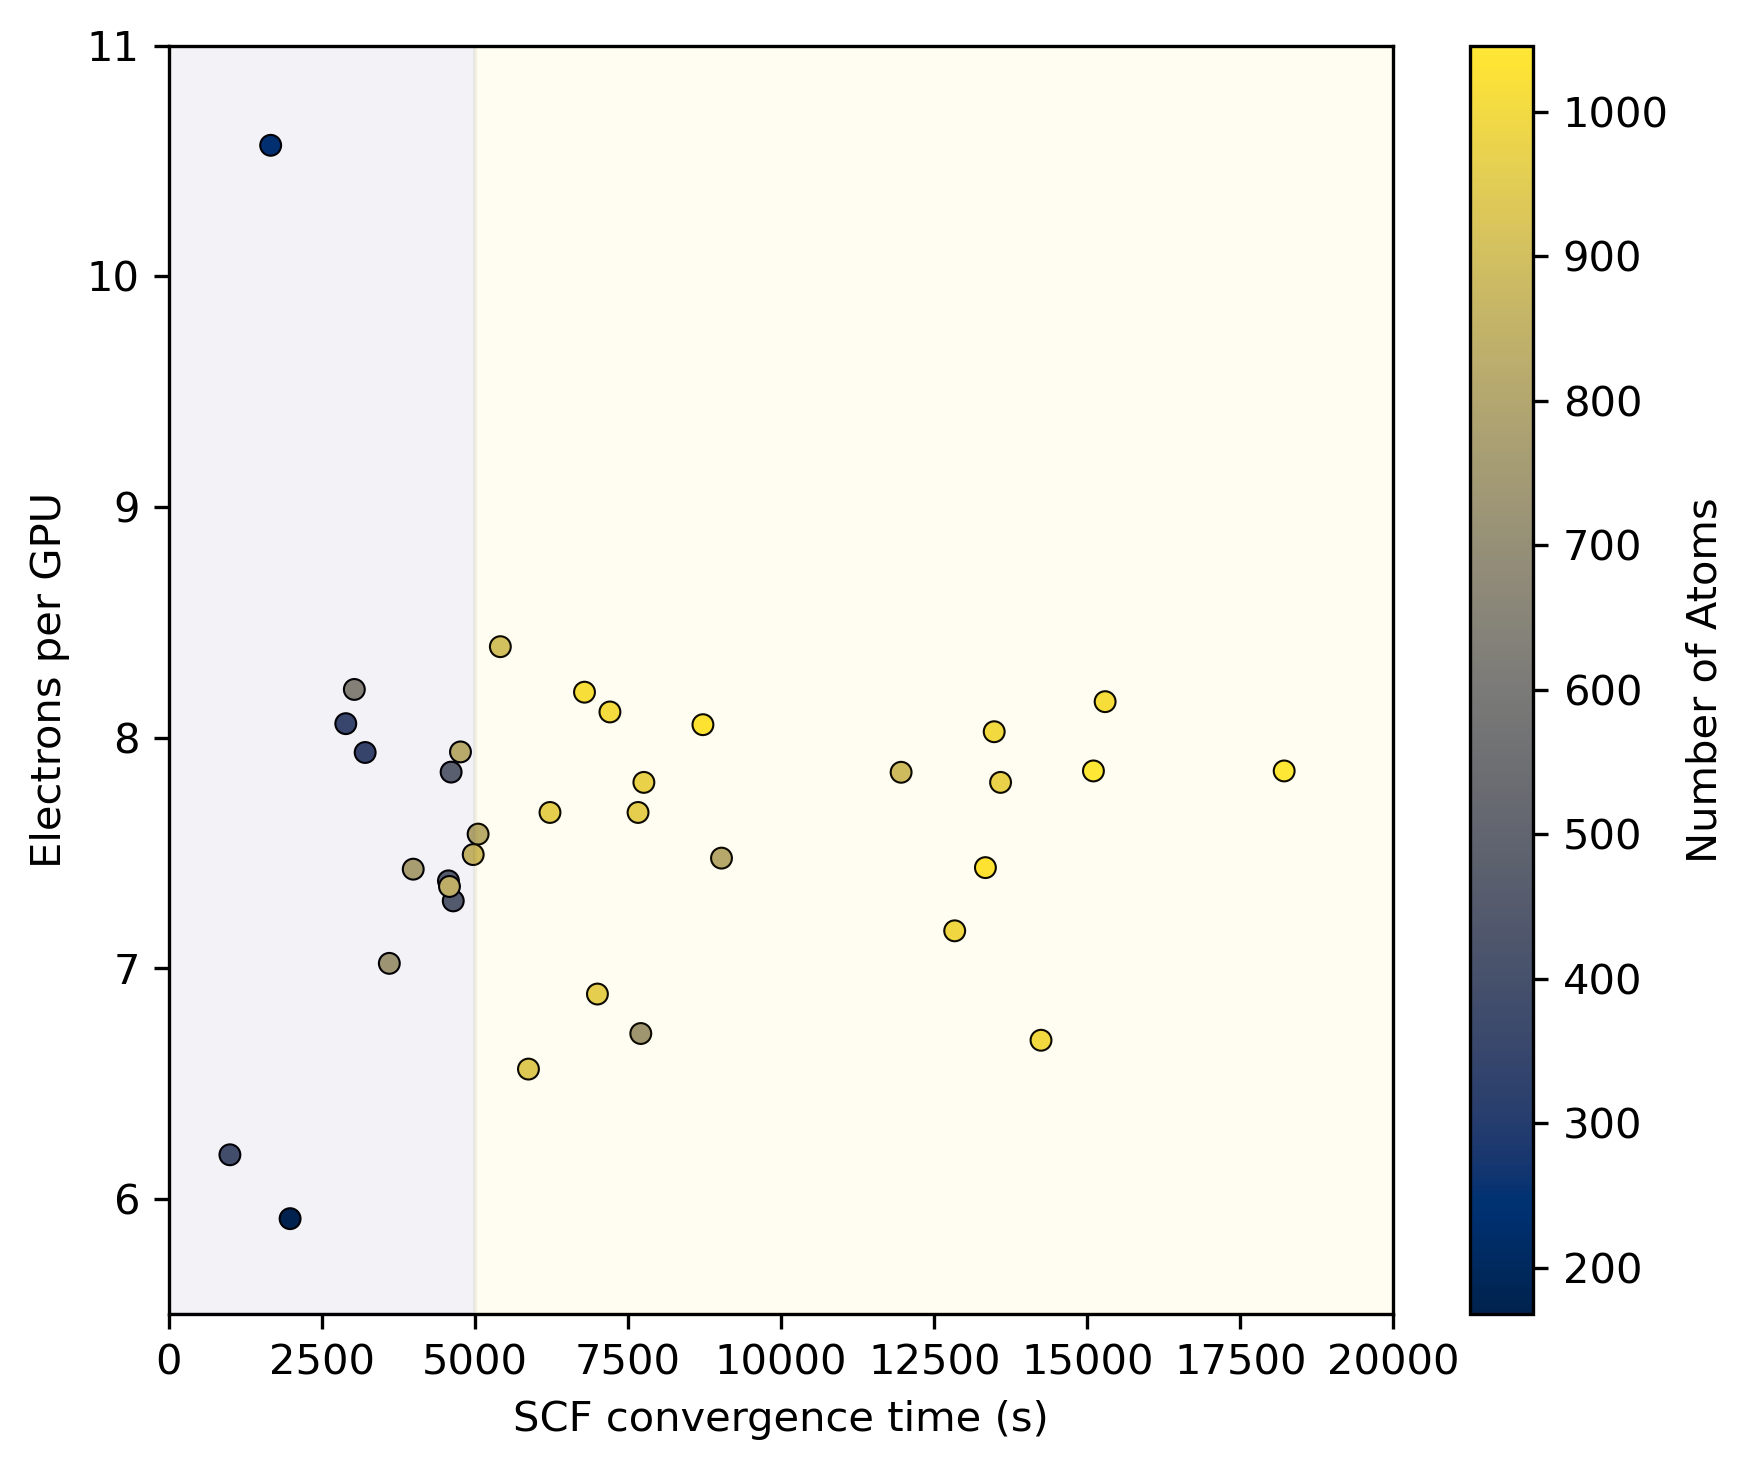

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.patches as patches

figure_3_plot_dct = format_for_plotting(input_dct)

# your data as numpy arrays
tt = np.array(figure_3_plot_dct['total_times'])
epg = np.array(figure_3_plot_dct['electrons_per_gpu'])
gcv = np.array(figure_3_plot_dct['grid_coefficient_of_variation'])
kdist = np.array(figure_3_plot_dct['kpoint_distribution'])
numatoms = np.array(figure_3_plot_dct['num_atoms'])

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=300, sharex=True, sharey=True)

# 1) define a global normalizer over the full range of gcv
ax2_norm = Normalize(vmin=numatoms.min(), vmax=numatoms.max())
ax2_cmap = plt.cm.cividis

# 2) loop over each k-distinct marker
mapping = {1: 'o'}
for kd, marker in mapping.items():
    mask = (kdist == kd)
    sc2 = ax.scatter(
        tt[mask], epg[mask],
        c=numatoms[mask],
        marker=marker,
        s=25,
        cmap=ax2_cmap,
        norm=ax2_norm,
        edgecolors='black',
        linewidth=0.5,
        label=f'kpt_dist={kd}'
    )

# Create a Rectangle patch
rect = patches.Rectangle((0, 5.5), 5000, 11 - 5.5,
                         linewidth=1, edgecolor='midnightblue', 
                         facecolor='midnightblue', alpha=0.05)

ax.add_patch(rect)
rect2 = patches.Rectangle((5000, 5.5), 20000, 11 - 5.5,
                         linewidth=1, edgecolor='gold', 
                         facecolor='gold', alpha=0.05)

ax.add_patch(rect2)

# 3) add one colorbar based on that shared mappable
cbar2 = fig.colorbar(sc2, ax=ax)
cbar2.set_label("Number of Atoms")

ax.set_xlabel("SCF convergence time (s)")
ax.set_ylabel("Electrons per GPU")
ax.set_xlim(0, 20000)
ax.set_ylim(5.5, 11)
#ax.legend(title="kpoint distribution")

fig.tight_layout()
#plt.show()

plt.savefig('fig_3_timing.png')

## Reformat Data

In [10]:
import numpy as np

def group_by_tolerance(x, y, z, labels, tol_angle=1e-3, tol_energy=1e-3):
    """
    Groups points (x,y) if they’re within tol_angle and tol_energy,
    collecting their labels and von Mises strains.

    Returns
    -------
    groups : list of dicts
        Each dict has keys:
          'x_rep'   : float, representative angle
          'y_rep'   : float, representative energy
          'labels'  : list of all labels in this bin
          'z_vals'  : list of all z’s (von Mises strains) in this bin
          'indices' : list of original indices in this bin
    """
    groups = []

    for i, (xi, yi, zi, lab) in enumerate(zip(x, y, z, labels)):
        placed = False
        for G in groups:
            if np.isclose(xi, np.mean(G['x_vals']), atol=tol_angle) and \
               np.isclose(yi, np.mean(G['y_vals']), atol=tol_energy):
                # Add into this existing group
                G['indices'].append(i)
                G['labels'].append(lab)
                G['z_vals'].append(zi)
                # (optionally) update the group representative to the mean
                #G['x_rep'] = np.mean([G['x_rep'], xi])
                #G['y_rep'] = np.mean([G['y_rep'], yi])
                G['x_vals'].append(xi)
                G['y_vals'].append(yi)
                placed = True
                break
        if not placed:
            # start a new group
            groups.append({
                'x_vals'   : [xi],
                'y_vals'   : [yi],
                'labels'  : [lab],
                'z_vals'  : [zi],
                'indices' : [i],
            })

    return groups

In [11]:
tol_angle, tol_energy = 1e-1, 1e-3
x = np.array(figure_3_plot_dct['folded_mod_new_angles'])
x_processed = np.where(np.isclose(x, 30.0, atol=tol_angle), x - 30.0, x)

y = np.array(figure_3_plot_dct['formation_energies'])
z = np.array(figure_3_plot_dct['von_mises_strain'])
z2 = np.array(figure_3_plot_dct['num_atoms'])
z3 = np.array(figure_3_plot_dct['band_gaps'])
labels = np.array(figure_3_plot_dct['labels'])

groups1 = group_by_tolerance(x_processed, y, z, labels, tol_angle=tol_angle, tol_energy=tol_energy)
groups2 = group_by_tolerance(x_processed, y, z2, labels, tol_angle=tol_angle, tol_energy=tol_energy)
groups3 = group_by_tolerance(x_processed, y, z3, labels, tol_angle=tol_angle, tol_energy=tol_energy)

In [12]:
# First, pull out the statistics:
modded_labels1 = [g['labels'] for g in groups1]
x_means1 = np.array([np.mean(g['x_vals']) for g in groups1])
x_stds1  = np.array([np.std (g['x_vals']) for g in groups1])
y_means1 = np.array([np.mean(g['y_vals']) for g in groups1])
y_stds1  = np.array([np.std (g['y_vals']) for g in groups1])
z_means1 = np.array([np.mean(g['z_vals']) for g in groups1])

modded_labels2 = [g['labels'] for g in groups2]
x_means2 = np.array([np.mean(g['x_vals']) for g in groups2])
x_stds2  = np.array([np.std (g['x_vals']) for g in groups2])
y_means2 = np.array([np.mean(g['y_vals']) for g in groups2])
y_stds2  = np.array([np.std (g['y_vals']) for g in groups2])
z_means2 = np.array([np.mean(g['z_vals']) for g in groups2])

# Figure 4. 

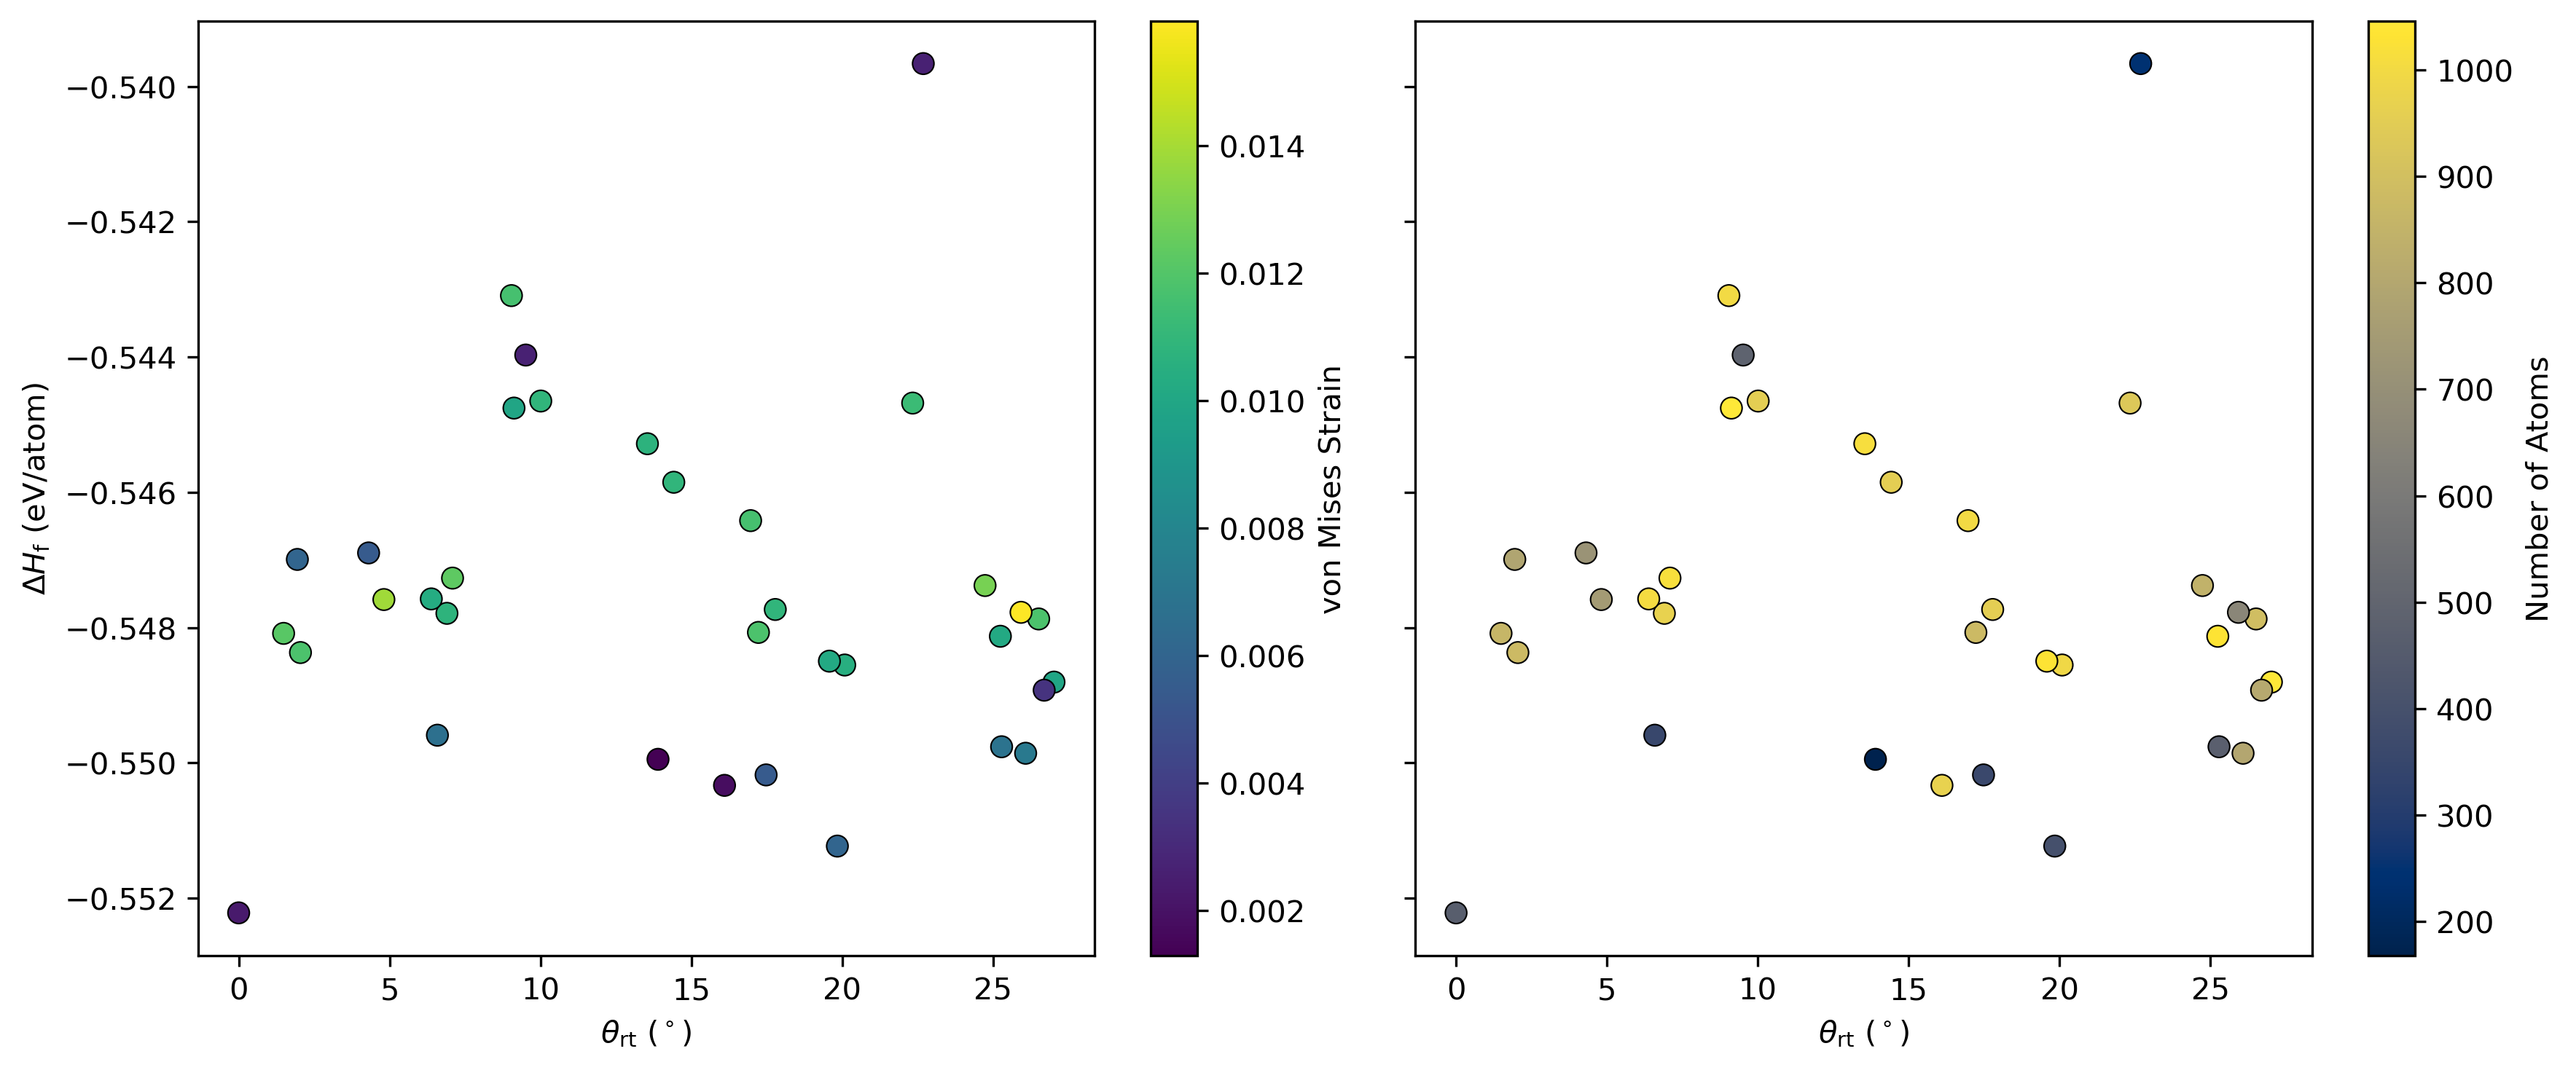

In [13]:
# Now plot:
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 5), dpi=300, sharex=True, sharey=True)
#fig3, ax3 = plt.subplots(1, 1, figsize=(6, 5), dpi=300)

# 1) scatter the group‐means, colored by avg. strain
sc31 = ax3[0].scatter(
    x_means1, y_means1,
    c=z_means1,
    s=50,
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5,
    zorder=2
)

ax3[0].set_xlabel(r'$\theta_{\mathrm{rt}}\ (^\circ)$')
ax3[0].set_ylabel(r'$\Delta H_{\mathrm{f}}\ (\mathrm{eV/atom})$')
cbar31 = fig3.colorbar(sc31, ax=ax3[0])
cbar31.set_label("von Mises Strain")

sc32 = ax3[1].scatter(
    x_means2, y_means2,
    c=z_means2,
    s=50,
    cmap='cividis',
    edgecolors='black',
    linewidth=0.5,
    zorder=2
)

ax3[1].set_xlabel(r'$\theta_{\mathrm{rt}}\ (^\circ)$')
#ax3[1].set_ylabel(r'$\Delta H_{\mathrm{f}}\ (\mathrm{eV/atom})$')
cbar32 = fig3.colorbar(sc32, ax=ax3[1])
cbar32.set_label("Number of Atoms")


fig3.tight_layout()
#plt.show()
#plt.savefig('energy.png')

/tmp/ipykernel_1861/2806075215.py:32: UserWarning: Adding colorbar to a different Figure <Figure size 3600x1500 with 3 Axes> than <Figure size 3600x1500 with 4 Axes> which fig.colorbar is called on.
  cbar41 = fig3.colorbar(sc41, ax=ax4[0])


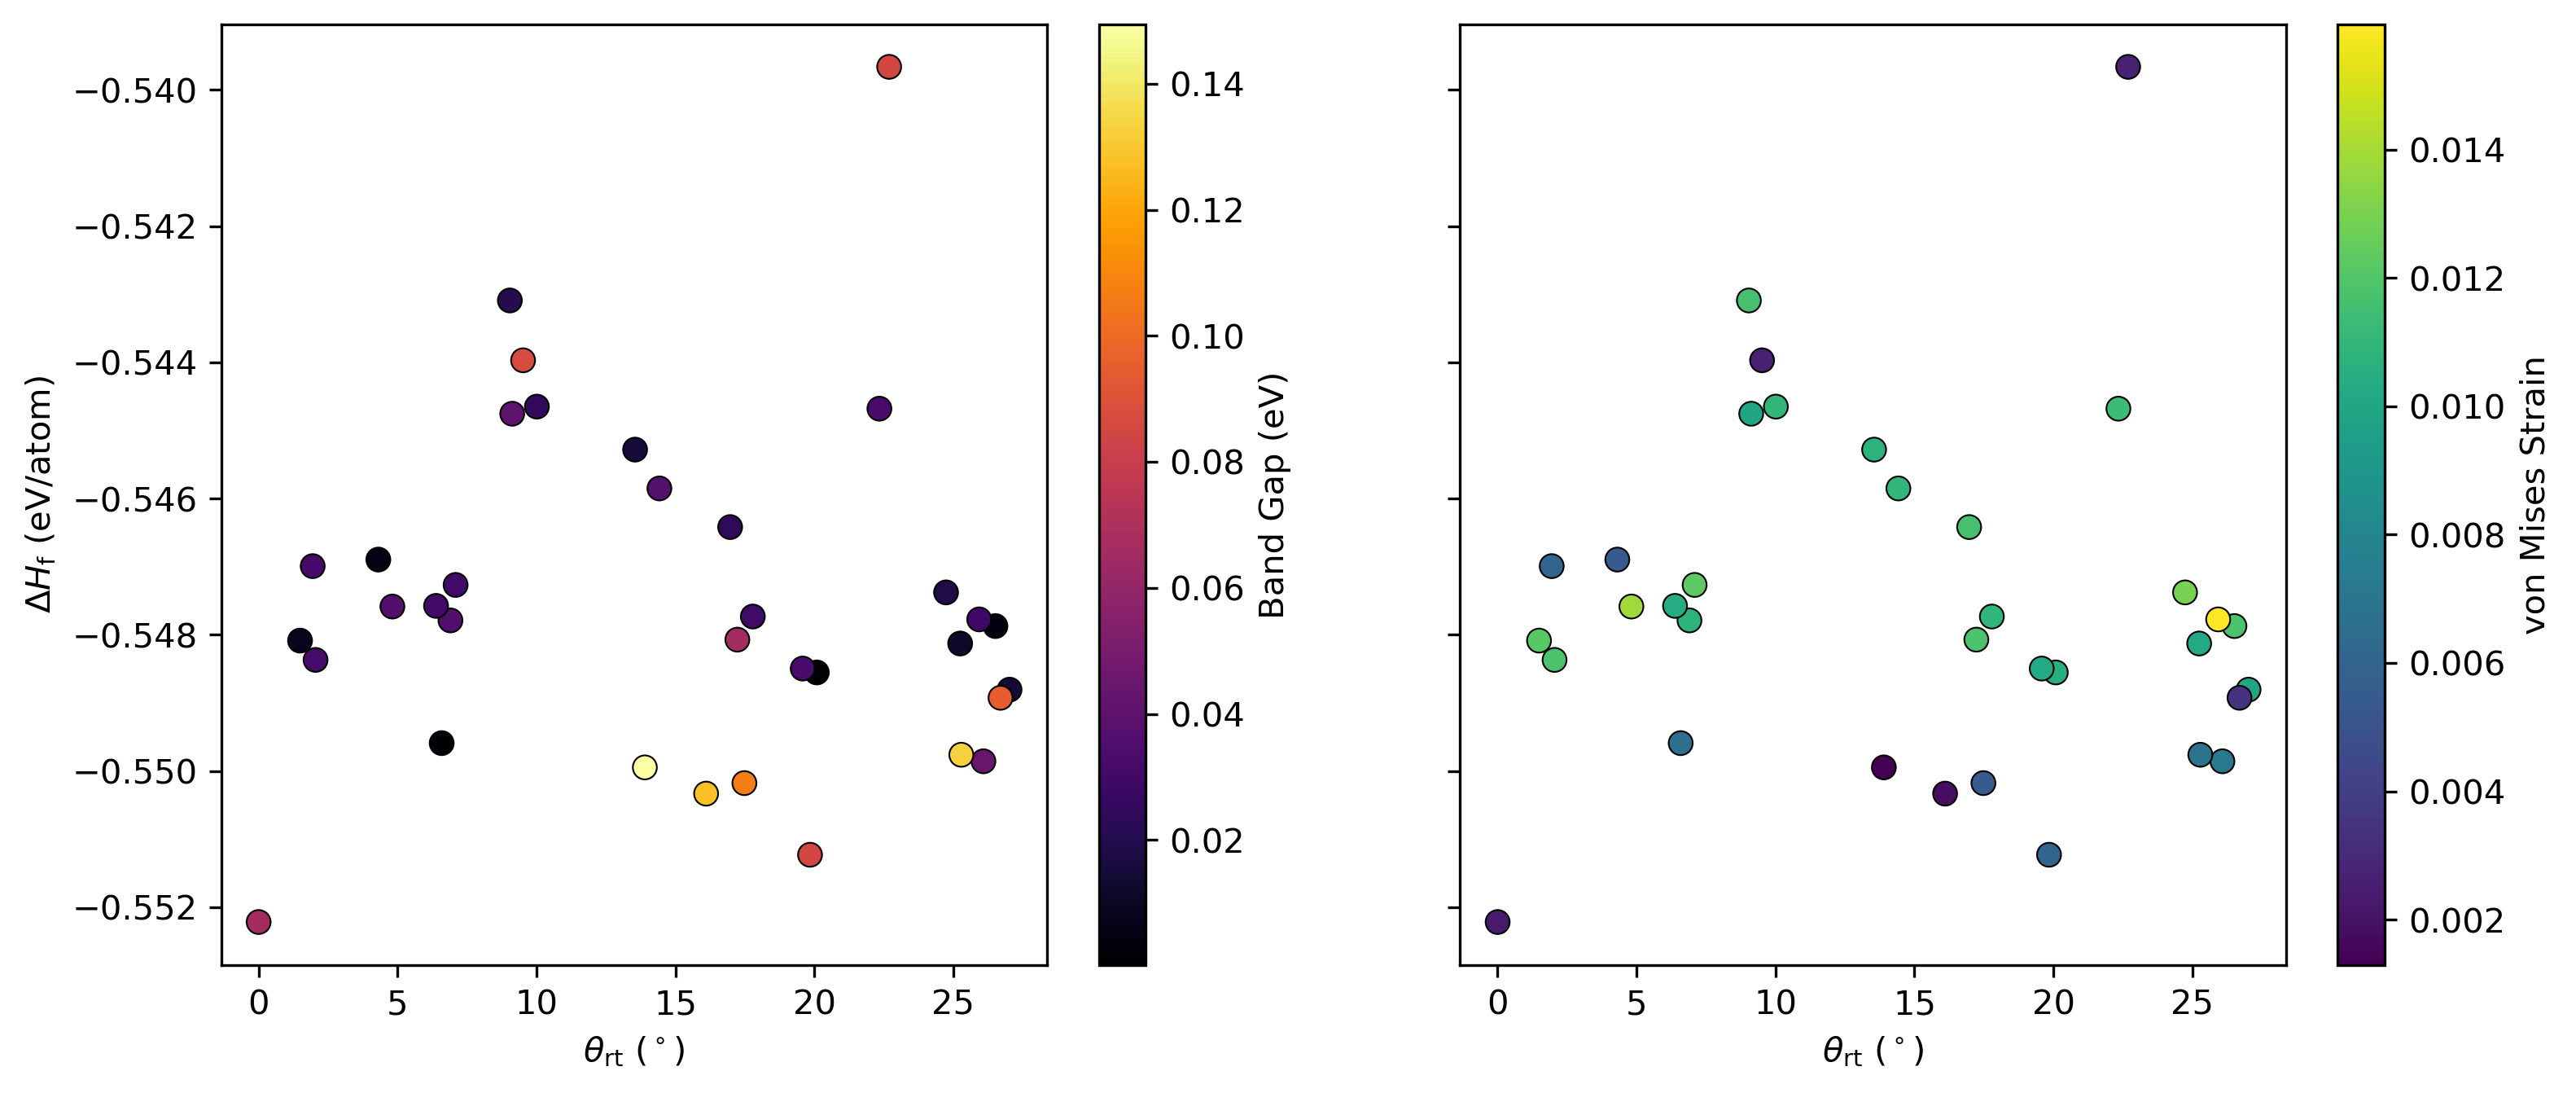

In [14]:
# First, pull out the statistics:
modded_labels3 = [g['labels'] for g in groups1]
x_means3 = np.array([np.mean(g['x_vals']) for g in groups3])
x_stds3  = np.array([np.std (g['x_vals']) for g in groups3])
y_means3 = np.array([np.mean(g['y_vals']) for g in groups3])
y_stds3  = np.array([np.std (g['y_vals']) for g in groups3])
z_means3 = np.array([np.mean(g['z_vals']) for g in groups3])

modded_labels2 = [g['labels'] for g in groups2]
x_means1 = np.array([np.mean(g['x_vals']) for g in groups1])
x_stds1  = np.array([np.std (g['x_vals']) for g in groups1])
y_means1 = np.array([np.mean(g['y_vals']) for g in groups1])
y_stds1  = np.array([np.std (g['y_vals']) for g in groups1])
z_means1 = np.array([np.mean(g['z_vals']) for g in groups1])

# Now plot:
fig4, ax4 = plt.subplots(1, 2, figsize=(12, 5), dpi=300, sharex=True, sharey=True)

# 1) scatter the group‐means, colored by avg. strain
sc41 = ax4[0].scatter(
    x_means3, y_means3,
    c=z_means3,
    s=50,
    cmap='inferno',
    edgecolors='black',
    linewidth=0.5,
    zorder=2
)

ax4[0].set_xlabel(r'$\theta_{\mathrm{rt}}\ (^\circ)$')
ax4[0].set_ylabel(r'$\Delta H_{\mathrm{f}}\ (\mathrm{eV/atom})$')
cbar41 = fig3.colorbar(sc41, ax=ax4[0])
cbar41.set_label("Band Gap (eV)")

sc42 = ax4[1].scatter(
    x_means1, y_means1,
    c=z_means1,
    s=50,
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5,
    zorder=2
)

ax4[1].set_xlabel(r'$\theta_{\mathrm{rt}}\ (^\circ)$')
#ax3[1].set_ylabel(r'$\Delta H_{\mathrm{f}}\ (\mathrm{eV/atom})$')
cbar42 = fig4.colorbar(sc42, ax=ax4[1])
cbar42.set_label("von Mises Strain")
plt.savefig('fig_4_gap_strain.png')

## Parse converged ion-optimized RMG calculations

In [15]:
input_name2 = 'optimized'
input_dct2 = get_rmg_logs_and_inputs(input_name2, 'references')

optimized/168/13.89789/0.0013
optimized/656/25.92854/0.01595
optimized/244/22.68889/0.00263
optimized/358/17.48017/0.00542
optimized/488/9.51534/0.00263
optimized/466/0.0/0.00232


In [16]:
figure_5_plot_dct = format_for_plotting(input_dct2)
check_labels = [os.path.join('small_strain_single_points', k) for k in list(figure_5_plot_dct['labels'])]
input_dct_small = {k: input_dct[k] for k in check_labels if k in input_dct}
figure_5_plot_dct_old = format_for_plotting(input_dct_small)

# Figure 5.

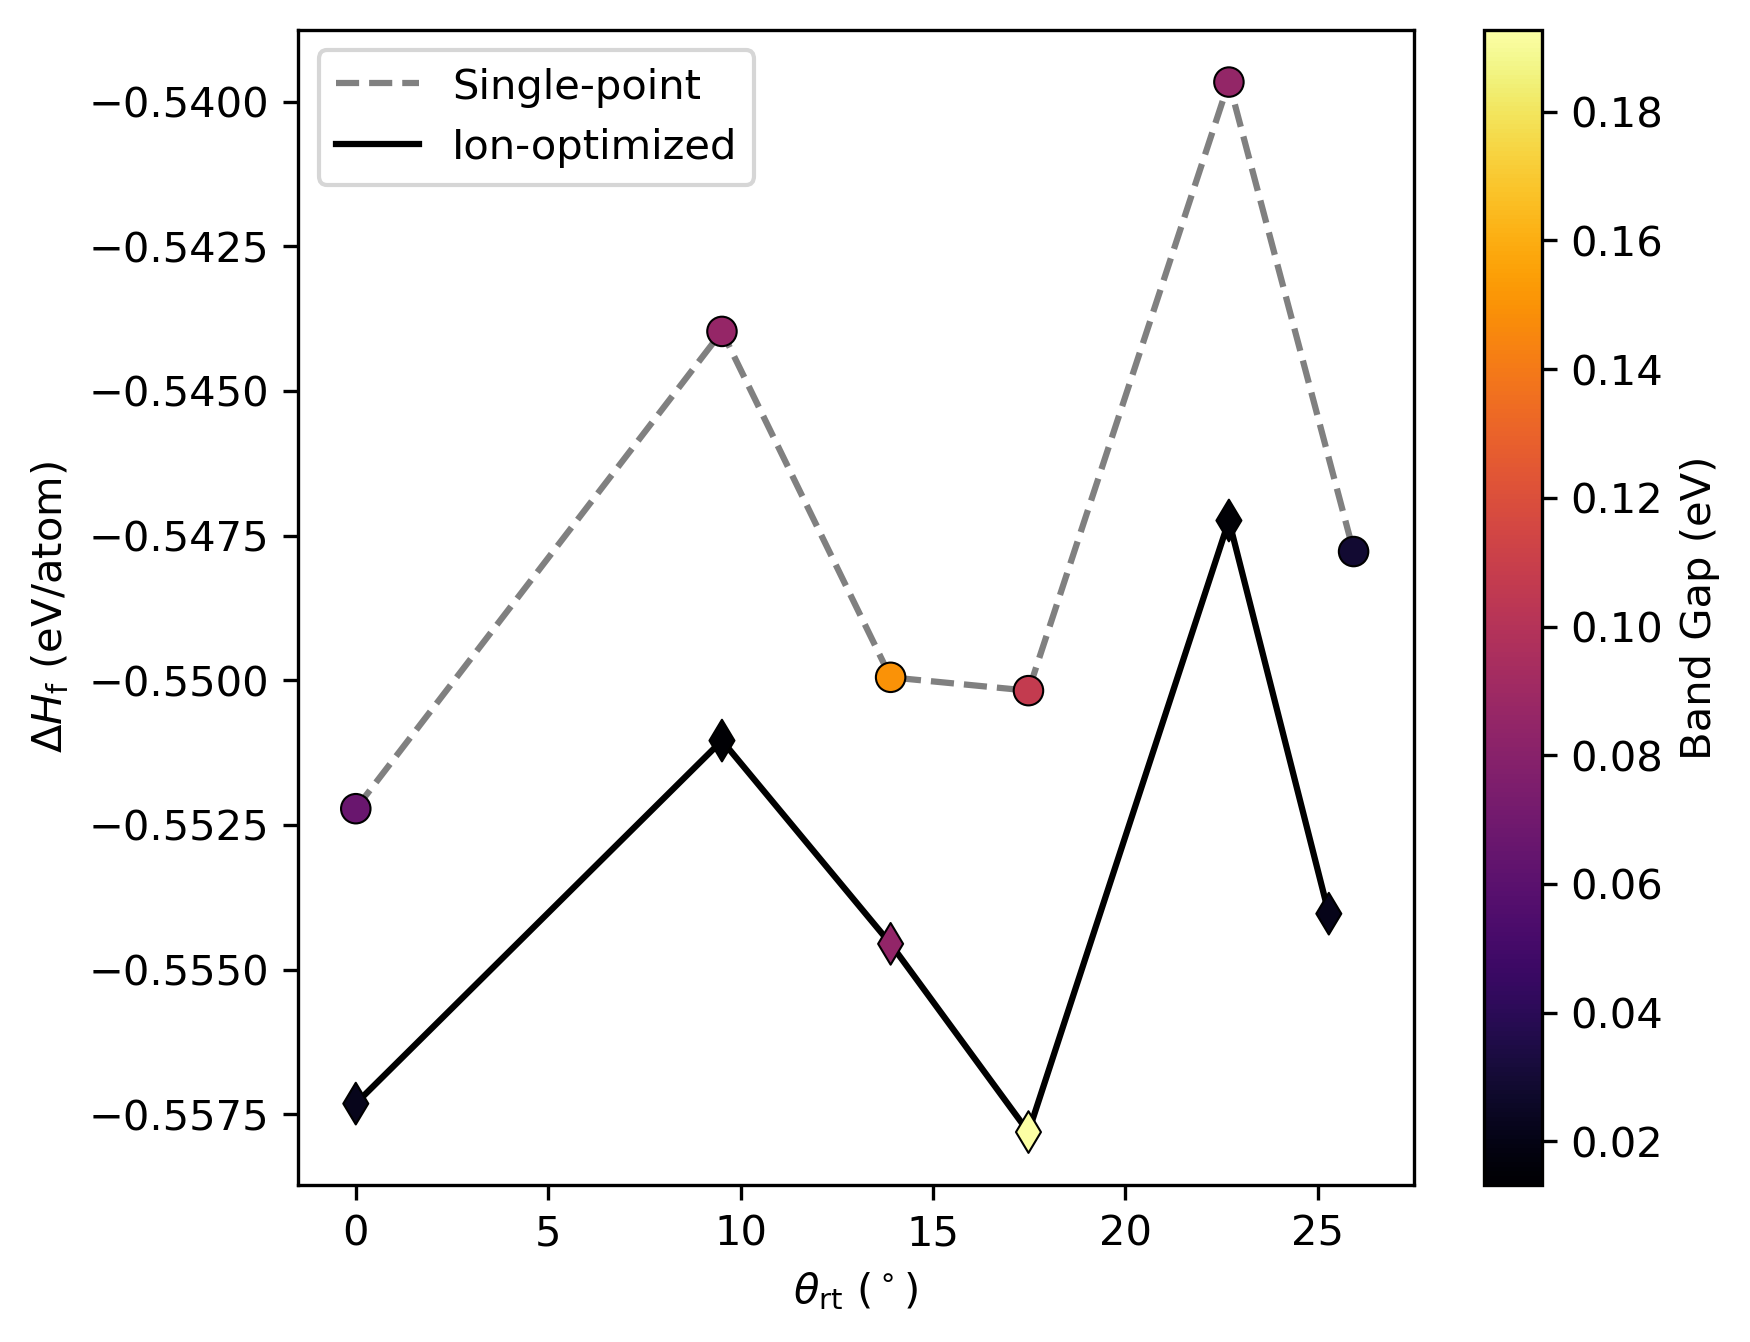

In [17]:
figure_5_plot_dct = format_for_plotting(input_dct2)

# Now plot:
fig5, ax5 = plt.subplots(1, 1, figsize=(6, 5), dpi=300)

# Shared color range
vmin = min(min(figure_5_plot_dct['band_gaps']), min(figure_5_plot_dct_old['band_gaps']))
vmax = max(max(figure_5_plot_dct['band_gaps']), max(figure_5_plot_dct_old['band_gaps']))

cmap = plt.cm.inferno  # choose any colormap

# 1) scatter the group‐means, colored by avg. strain'''

stwist, so_fes = zip(*sorted(zip(figure_5_plot_dct_old['folded_mod_new_angles'], 
                                 figure_5_plot_dct_old['formation_energies'])))
ax5.plot(stwist, so_fes, 
         linestyle='--', color='grey', label='Single-point')

sc51 = ax5.scatter(
    figure_5_plot_dct_old['folded_mod_new_angles'], 
    figure_5_plot_dct_old['formation_energies'],
    c=figure_5_plot_dct_old['band_gaps'],
    s=50,
    cmap=cmap,
    edgecolors='black',
    linewidth=0.5,
    zorder=2, 
    vmin=vmin, vmax=vmax, marker='o',
)

stwist, sn_fes = zip(*sorted(zip(figure_5_plot_dct['folded_mod_new_angles'], 
                                 figure_5_plot_dct['formation_energies'])))
ax5.plot(stwist, sn_fes, linestyle='-', color='black', label='Ion-optimized')

sc52 = ax5.scatter(
    figure_5_plot_dct['folded_mod_new_angles'], 
    figure_5_plot_dct['formation_energies'],
    c=figure_5_plot_dct['band_gaps'],
    s=50,
    cmap=cmap,
    edgecolors='black',
    linewidth=0.5,
    zorder=2, 
    vmin=vmin, vmax=vmax, marker='d'
)

ax5.set_xlabel(r'$\theta_{\mathrm{rt}}\ (^\circ)$')
ax5.set_ylabel(r'$\Delta H_{\mathrm{f}}\ (\mathrm{eV/atom})$')
ax5.set_xlim(-1.5, 27.5)
cbar51 = fig5.colorbar(sc51, ax=ax5)
cbar51.set_label("Band Gap (eV)")
ax5.legend()
fig.tight_layout()
plt.savefig('fig_5_sp_opt.png', bbox_inches='tight', dpi=300)

# Supplementary Information

In [18]:
## Import based on different formatting

In [19]:
def angle_between_vectors(v1, v2):
    """Compute the angle (in degrees) between two vectors."""
    dot_product = np.dot(v1, v2)
    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)
    cos_theta = np.clip(dot_product / (mag_v1 * mag_v2), -1.0, 1.0)  # Avoid numerical errors
    return np.degrees(np.arccos(cos_theta))

def apply_transformation(transformation, vectors):
    """Apply a 2x2 transformation matrix to a set of 2D vectors."""
    return np.dot(transformation, np.array(vectors)[:, :2].T).T  # Ignore z-component

def all_transformations(film_vectors, film_transformation, substrate_vector, substrate_transformation):
    # Compute initial angles
    initial_angle_1 = angle_between_vectors(film_vectors[0], substrate_vectors[0])
    initial_angle_2 = angle_between_vectors(film_vectors[1], substrate_vectors[1])

    # Transform vectors
    transformed_film_vectors = apply_transformation(film_transformation, film_vectors)
    transformed_substrate_vectors = apply_transformation(substrate_transformation, substrate_vectors)

    # Compute new angles
    transformed_angle_1 = angle_between_vectors(transformed_film_vectors[0], transformed_substrate_vectors[0])
    transformed_angle_2 = angle_between_vectors(transformed_film_vectors[1], transformed_substrate_vectors[1])

    # Compute rotation due to transformation
    rotation_due_to_transformation_1 = transformed_angle_1 - initial_angle_1
    rotation_due_to_transformation_2 = transformed_angle_2 - initial_angle_2
    return rotation_due_to_transformation_1, rotation_due_to_transformation_2

def sort_lists_by_index(sort_index, *lists):
    if not lists:
        raise ValueError("At least one list must be provided")
    
    if any(len(lst) != len(lists[0]) for lst in lists):
        raise ValueError("All lists must have the same length")
    
    zipped_lists = list(zip(*lists))  # Zip the lists together
    sorted_lists = sorted(zipped_lists, key=lambda x: x[sort_index])  # Sort by the specified index
    
    return tuple(map(list, zip(*sorted_lists)))  # Unzip back into separate lists

def polar_decomposition(substrate_sl_vectors, film_sl_vectors):
    s1, s2 = substrate_sl_vectors[0][:2], substrate_sl_vectors[1][:2]
    f1, f2 = film_sl_vectors[0][:2], film_sl_vectors[1][:2]

    S = np.column_stack([s1, s2])   # shape (2,2)
    F = np.column_stack([f1, f2])   # shape (2,2)

    M = F @ np.linalg.inv(S)
    U = sqrtm(M.T @ M)    # shape (2,2), symmetric by construction
    R = M @ np.linalg.inv(U)
    angle_rad = np.arctan2(R[1,0], R[0,0])
    angle_deg = np.degrees(angle_rad)

    return angle_deg

def parse_stress_vectors(rmg_path):
    rp = RMGParser(rmg_path)
    stress_collection = rp.parse_stress_vectors()
    stress = np.array([stress_collection.properties[0].vector, 
              stress_collection.properties[1].vector, 
              stress_collection.properties[2].vector])
    return stress # numpy 2D array

def von_Mises_stress(stress_vector):
    sym_stress = stress_vector.copy()
    # List of off-diagonal index pairs to symmetrize
    index_pairs = [(0, 1), (0, 2), (1, 2)]
    for i, j in index_pairs:
        avg = 0.5 * (stress_vector[i, j] + stress_vector[j, i])
        sym_stress[i, j] = avg
        sym_stress[j, i] = avg
        
    von_Mises_stress = Strain(sym_stress).von_mises_strain
    return von_Mises_stress # scalar 

In [20]:
def get_reference_energy(structure, energy, reference_logs):
    final_structures = [ref_log.logs_data[ref_log.logs_keys[-1]]['structures'][-1] for ref_log in reference_logs]
    elements_lst = [str(s[0].specie) for s in final_structures] # Get first element
    final_energies = [ref_log.logs_data[ref_log.logs_keys[-1]]['energies'][-1] for ref_log in reference_logs]
    ref_dict = {elements_lst[i]: final_energies[i]/len(final_structures[i]) for i, element in enumerate(elements_lst)}
    #print(ref_dict)
    
    structure_comp_dct = structure.composition.as_dict()
    comp_elements = list(structure_comp_dct.keys())
    #print(structure_comp_dct, comp_elements)
    energies_per_element = [structure_comp_dct[element] * ref_dict[element] for element in comp_elements]
    
    formation_energy = energy - sum(energies_per_element)
    formation_energy = formation_energy / len(structure) # Normalization per atom, in units Hartree/atom
    formation_energy *= 27.2114 # Conversion from Hartree/atom to eV/atom
            
    return formation_energy

def get_total_electrons(structure):
    return np.sum([ONCVValences().get_valence(str(site.specie)) for site in structure])

def get_from_top(path):
    rmg_input_path = os.path.join(path, 'rmg_input')
    forcefield_path = os.path.join(path, 'forcefield.xml')
    interface_path = os.path.join(path, 'interface.json')
        
    if os.path.exists(rmg_input_path):
        rmg_input = RMGInput(input_file=rmg_input_path)
        
        if os.path.exists(forcefield_path):
            forcefield = Forcefield(forcefield_xml_path=forcefield_path)
            convergence_checker = RMGConvergence(forcefield=forcefield, 
                                                 rmg_input=rmg_input)
            
            if convergence_checker.is_converged():
                rmg_log = RMGLog(path)
                return rmg_input, rmg_log, forcefield
            else:
                try:
                    rmg_log = RMGLog(path)
                except:
                    rmg_log = None
                return rmg_input, rmg_log, None
        else:
            return rmg_input, None, None
    else:
        return None, None, None

def get_rmg_logs_and_inputs_old(path, reference_path):
    reference_logs = []
    for root, _, _ in os.walk(reference_path):
        rmg_input, rmg_log, forcefield = get_from_top(root)
        if rmg_input:
            reference_logs.append(rmg_log)
    
    paths_dct = {}
    for root, _, _ in os.walk(path):
        rmg_input, rmg_log, forcefield = get_from_top(root)
        if rmg_input and rmg_log and forcefield:
            
            path_dct = {}
            path_dct['rmg_input'] = rmg_input
            path_dct['rmg_log'] = rmg_log
            last_log = rmg_log.logs_keys[-1]
                
            with open(last_log, 'r') as f:
                last_logfile = f.readlines()

            interface_path = os.path.join(root, 'interface.json')
            with open(interface_path, 'r') as j:
                interface_dct = json.load(j)
                
            correct_line = None
            for line in last_logfile:
                if "1-TOTAL" in line:
                    correct_line = line
                    break
            split_timings = correct_line.split()

            path_dct['valence_electrons'] = get_total_electrons(rmg_input.structure)
            path_dct['total_time'] = float(split_timings[1])
            path_dct['per_scf'] = float(split_timings[2])
            path_dct['wavefunction_grid'] = [int(i) for i in rmg_input.keywords['wavefunction_grid'].split()]
            path_dct['processor_grid'] = [int(i) for i in rmg_input.keywords['processor_grid'].split()]
            path_dct['kpoint_distribution'] = int(rmg_input.keywords.get('kpoint_distribution', 1))

            path_dct['strain'] = interface_dct['strain']
            path_dct['von_mises_strain'] = interface_dct['von_mises_strain']
            path_dct['signed_angle'] = interface_dct['signed_angle']
            path_dct['substrate_sl_vectors'] = interface_dct['substrate_sl_vectors']
            path_dct['film_sl_vectors'] = interface_dct['film_sl_vectors']

            path_dct['decomposition_angle']= polar_decomposition(interface_dct['substrate_sl_vectors'], 
                                                                interface_dct['film_sl_vectors'])

            final_structure = rmg_log.logs_data[last_log]['structures'][-1]
            final_energy = rmg_log.logs_data[last_log]['energies'][-1] 
            rmg_parser = RMGParser(root)
            final_stress = parse_stress_vectors(root)
            
            path_dct['reduction_factor'] = [1, 1, 1 - (15/final_structure.lattice.c)]
            #print(final_stress)
            path_dct['von_mises_stress'] = von_Mises_stress(final_stress)
            path_dct['formation_energy (meV/atom)'] = get_reference_energy(final_structure, 
                                                                    final_energy, 
                                                                    reference_logs)
            
            paths_dct[root] = path_dct
        else:
            continue
            #print(f'{rmg_input_path} not converged!')
            
    return paths_dct

In [21]:
input_dct_SI = get_rmg_logs_and_inputs_old('original_single_points', 'references')
sup_fig_plot_dct = format_for_plotting(input_dct_SI)

# Figure B2. 

In [22]:
tol_angle, tol_energy = 1e-1, 1e-3
x = np.array(sup_fig_plot_dct['mod_new_angles'])
x_processed = np.where(np.isclose(x, 60.0, atol=tol_angle), x - 60.0, x)
x2 = np.array(sup_fig_plot_dct['folded_mod_new_angles'])
x2_processed = np.where(np.isclose(x2, 30.0, atol=tol_angle), x2 - 30.0, x2)

y = np.array(sup_fig_plot_dct['formation_energies'])
z = np.array(sup_fig_plot_dct['von_mises_strain'])
labels = np.array(sup_fig_plot_dct['labels'])

groups1 = group_by_tolerance(x_processed, y, z, labels, tol_angle=tol_angle, tol_energy=tol_energy)
groups2 = group_by_tolerance(x2_processed, y, z, labels, tol_angle=tol_angle, tol_energy=tol_energy)

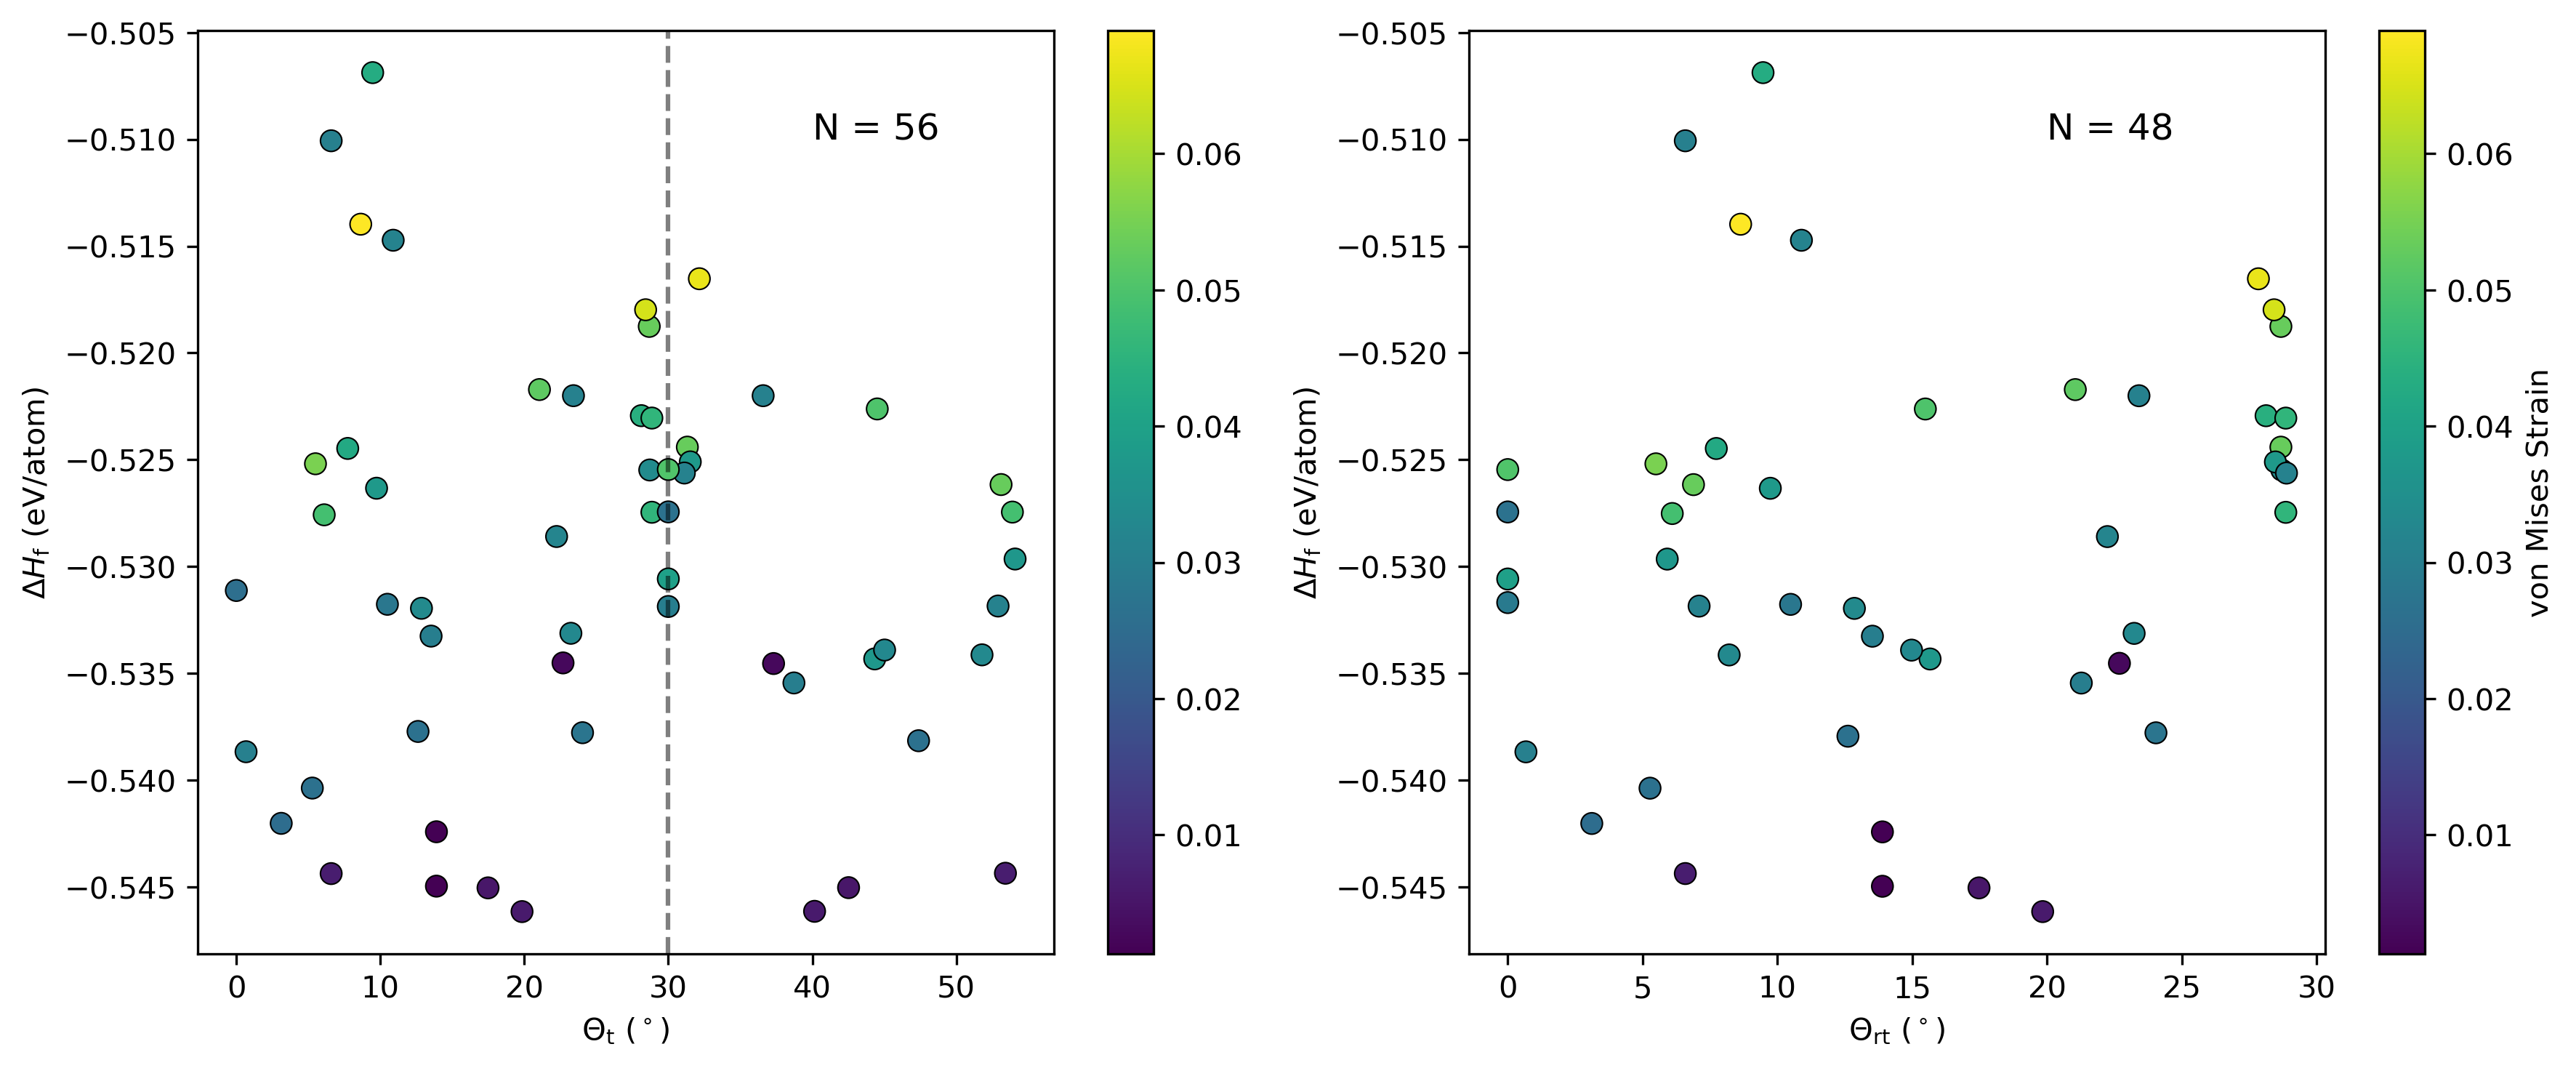

In [23]:
# First, pull out the statistics:
modded_labels = [g['labels'] for g in groups1]
x_means = np.array([np.mean(g['x_vals']) for g in groups1])
x_stds  = np.array([np.std (g['x_vals']) for g in groups1])
y_means = np.array([np.mean(g['y_vals']) for g in groups1])
y_stds  = np.array([np.std (g['y_vals']) for g in groups1])
z_means = np.array([np.mean(g['z_vals']) for g in groups1])

# Now plot:
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# 1) scatter the group‐means, colored by avg. strain
sc31 = ax3[0].scatter(
    x_means, y_means,
    c=z_means,
    s=50,
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5,
    zorder=2
)

ax3[0].set_xlabel(r'$\Theta_{\mathrm{t}}\ (^\circ)$')
ax3[0].set_ylabel(r'$\Delta H_{\mathrm{f}}\ (\mathrm{eV/atom})$')
ax3[0].axvline(x=30, linestyle='--', color='black', alpha=0.5)
cbar31 = fig3.colorbar(sc31, ax=ax3[0])
ax3[0].text(40, -0.51, f'N = {len(x_means)}', fontsize=12)

modded_labels2 = [g['labels'] for g in groups2]
x_means2 = np.array([np.mean(g['x_vals']) for g in groups2])
x_stds2  = np.array([np.std (g['x_vals']) for g in groups2])
y_means2 = np.array([np.mean(g['y_vals']) for g in groups2])
y_stds2  = np.array([np.std (g['y_vals']) for g in groups2])
z_means2 = np.array([np.mean(g['z_vals']) for g in groups2])

# Now plot:

# 1) scatter the group‐means, colored by avg. strain
sc32 = ax3[1].scatter(
    x_means2, y_means2,
    c=z_means2,
    s=50,
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5,
    zorder=2
)

ax3[1].set_xlabel(r'$\Theta_{\mathrm{rt}}\ (^\circ)$')
ax3[1].set_ylabel(r'$\Delta H_{\mathrm{f}}\ (\mathrm{eV/atom})$')
cbar32 = fig3.colorbar(sc32, ax=ax3[1])
cbar32.set_label("von Mises Strain")
ax3[1].text(20, -0.51, f'N = {len(x_means2)}', fontsize=12)

fig3.tight_layout()
#plt.show()
plt.savefig('fig_sb2_twist.png')

# Figure B3. 

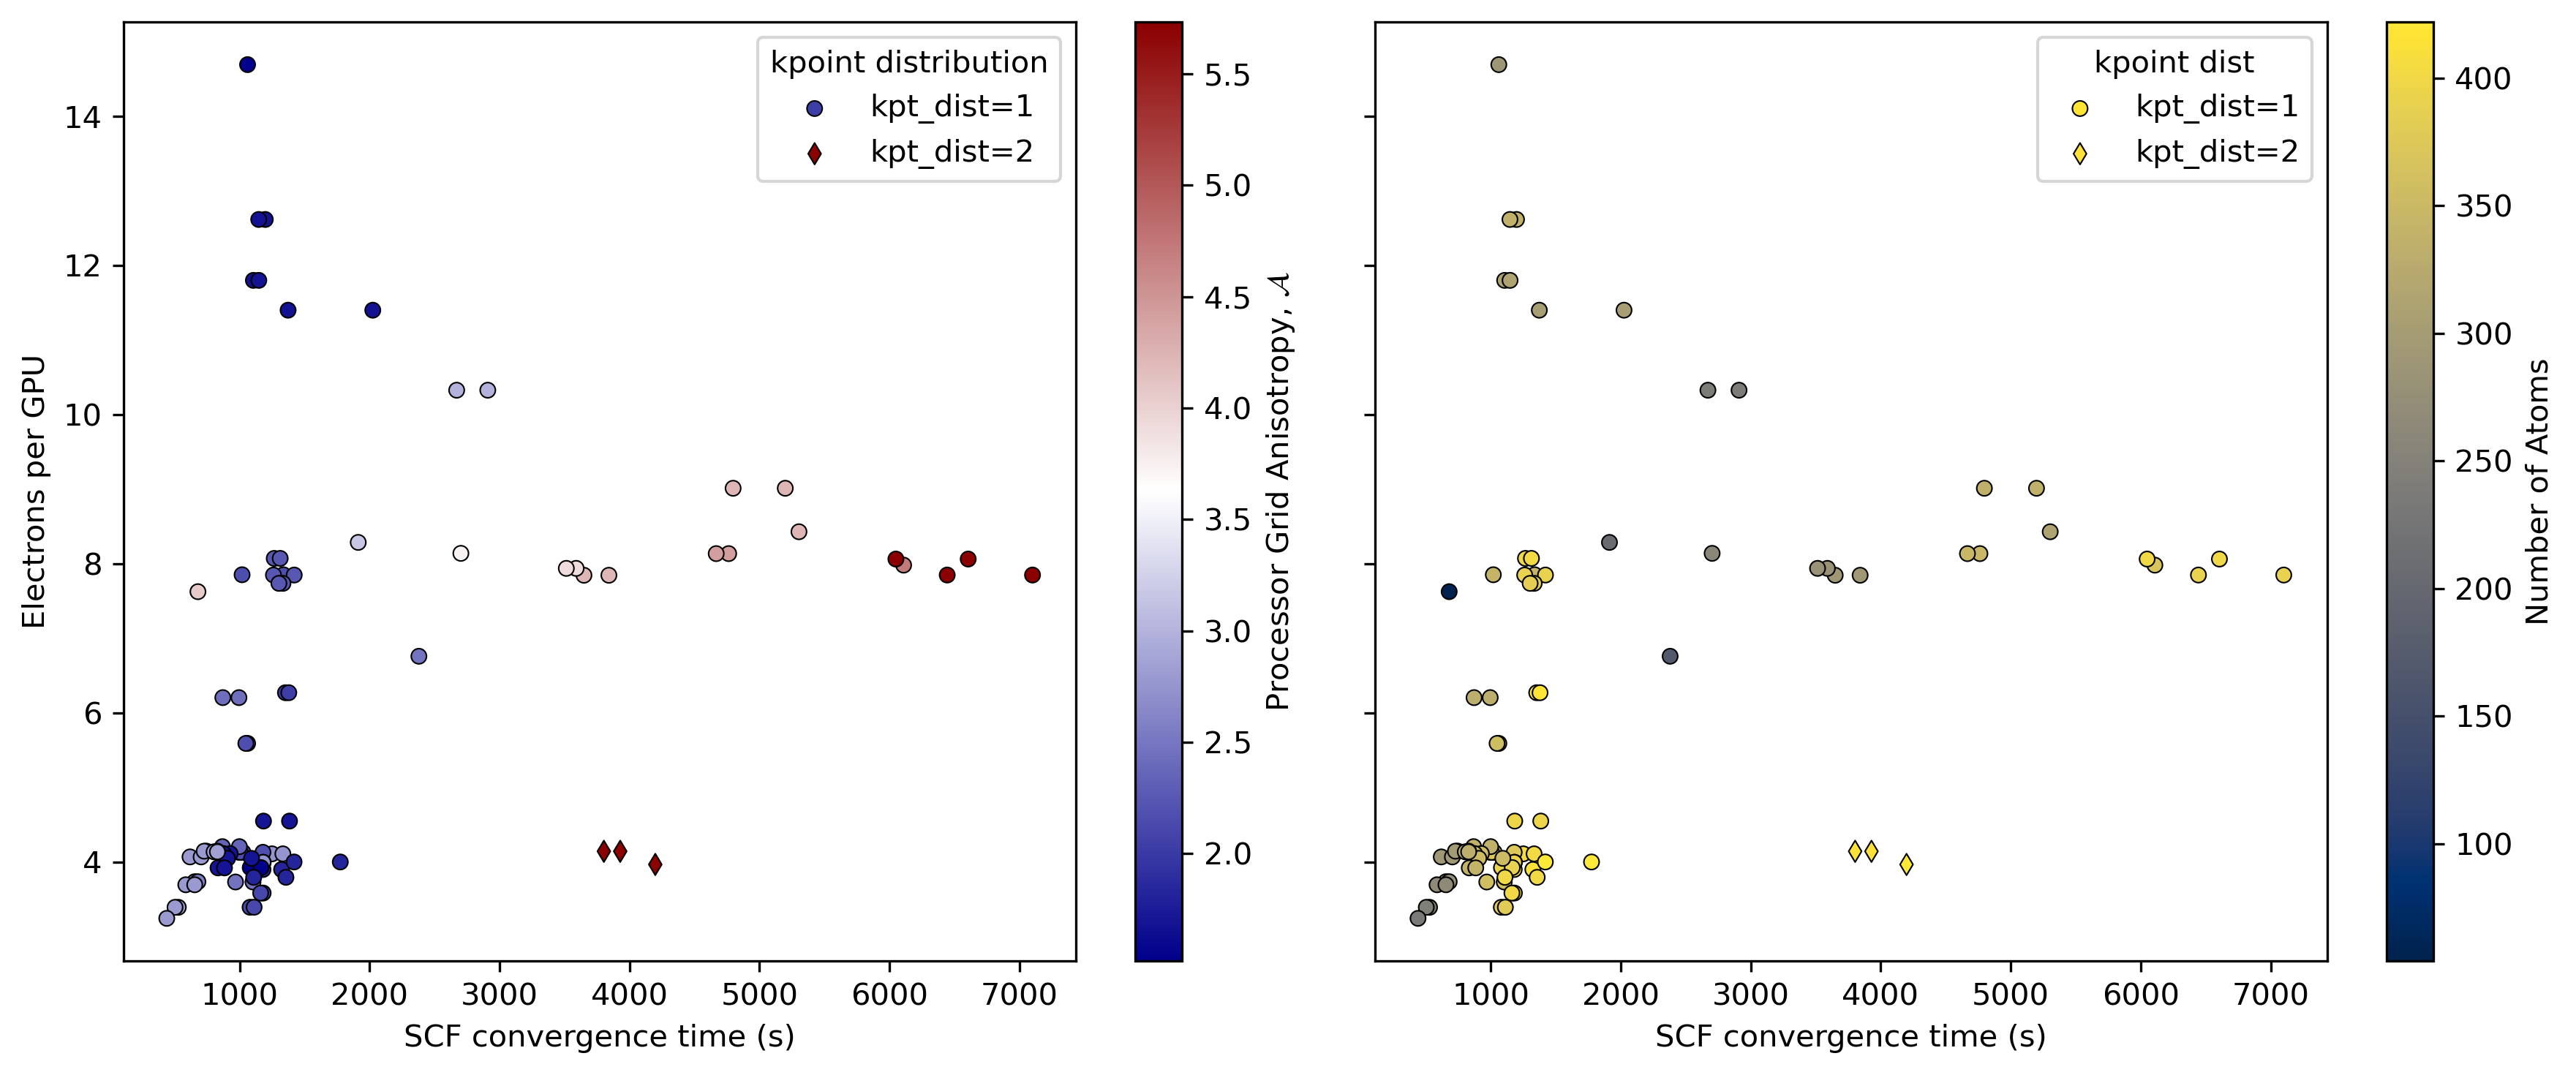

In [24]:
# your data as numpy arrays
tt = np.array(sup_fig_plot_dct['total_times'])
epg = np.array(sup_fig_plot_dct['electrons_per_gpu'])
gcv = np.array(sup_fig_plot_dct['grid_coefficient_of_variation'])
kdist = np.array(sup_fig_plot_dct['kpoint_distribution'])
numatoms = np.array(sup_fig_plot_dct['num_atoms'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300, sharex=True, sharey=True)

# marker mapping
mapping = {1: 'o', 2: 'd'}

# 1) define a global normalizer over the full range of gcv
ax1_norm = Normalize(vmin=gcv.min(), vmax=gcv.max())
from matplotlib.colors import LinearSegmentedColormap
colors = ["darkblue", "white", "darkred"]
ax1_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", colors)
#ax1_cmap = plt.cm.magma

# 2) loop over each k-distinct marker
for kd, marker in mapping.items():
    mask = (kdist == kd)
    sc1 = ax[0].scatter(
        tt[mask], epg[mask],
        c=gcv[mask],
        marker=marker,
        s=25,
        cmap=ax1_cmap,
        norm=ax1_norm,
        edgecolors='black',
        linewidth=0.5,
        label=f'kpt_dist={kd}'
    )

# 3) add one colorbar based on that shared mappable
cbar = fig.colorbar(sc1, ax=ax[0])
cbar.set_label("Processor Grid Anisotropy, $\mathcal{A}$")

ax[0].set_xlabel("SCF convergence time (s)")
ax[0].set_ylabel("Electrons per GPU")
ax[0].legend(title="kpoint distribution")

# 1) define a global normalizer over the full range of gcv
ax2_norm = Normalize(vmin=numatoms.min(), vmax=numatoms.max())
ax2_cmap = plt.cm.cividis

# 2) loop over each k-distinct marker
for kd, marker in mapping.items():
    mask = (kdist == kd)
    sc2 = ax[1].scatter(
        tt[mask], epg[mask],
        c=numatoms[mask],
        marker=marker,
        s=25,
        cmap=ax2_cmap,
        norm=ax2_norm,
        edgecolors='black',
        linewidth=0.5,
        label=f'kpt_dist={kd}'
    )

# 3) add one colorbar based on that shared mappable
cbar2 = fig.colorbar(sc2, ax=ax[1])
cbar2.set_label("Number of Atoms")

ax[1].set_xlabel("SCF convergence time (s)")
#ax[1].set_ylabel("Electrons per GPU")
ax[1].legend(title="kpoint dist")

fig.tight_layout()
#plt.show()

plt.savefig('fig_sb3_timing.png')